In [35]:
## imports ##
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn import svm, decomposition, tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.model_selection import learning_curve, GridSearchCV, cross_val_score, validation_curve
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import warnings
from sklearn.feature_selection import RFECV, SelectKBest, chi2, SelectFromModel, RFE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline

warnings.simplefilter("ignore")
np.random.seed(100)

## Contents:

- Gait data being used is based on the PDKit mPowerV1 data, collapsed by each healthCode ids
- Features chosen are based on a feature_engineering.ipnb
- For this ML Analysis, we will split the training-test set by 20%
- Parameters will be searched through grid search (GridSearchCV) and the score is assessed using Stratified 10-Fold Validation 
- Models being used: Logistic Regression, Xtreme Gradient Boost, Sklearn Gradient Boost and Random Forests
- Feature elimination will be done on several model using recursive feature elimination CV (Sklearn RFECV package)
- Learning Curves of each model (Work in progress)
- Best model will be dump into .pkl file (Work in progress)

## Helper Functions

In [51]:
def KBest_features_columns(X_train, y_train):
    selector = SelectKBest(chi2, k=15).fit(X_train, y_train)
    selected_columns = X_train.columns[selector.get_support()]
    return selected_columns
    
def logreg_fit(X_train, y_train):
    pipe = Pipeline(steps=[
#         ('scaler', MinMaxScaler()),
        ('classifier', LogisticRegression(random_state = 100))
        ])
    param = [{'classifier__penalty': ['l2'], 
              'classifier__solver': [ 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}, 
             {'classifier__penalty': ['l1'], 
              'classifier__solver': [ 'liblinear', 'saga']}  
            ]

    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV


def xgb_fit(X_train, y_train):
    pipe = Pipeline(steps=[
#         ('scaler', MinMaxScaler()),
        ('classifier', XGBClassifier(seed = 100))
        ])
    param = {
        "classifier__learning_rate" : [0.01, 0.05, 0.1],
        "classifier__tree_method"   : ["hist", "auto"],
        "classifier__max_depth"     : [6, 8],
        "classifier__gamma"         : [0, 1],
        "classifier__subsample"     : [0.8],
        "classifier__n_estimators"  : [100]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV
    

def gradientboost_fit(X_train, y_train):
    pipe = Pipeline(steps=[
#         ('scaler', MinMaxScaler()),
        ('classifier', GradientBoostingClassifier(random_state = 100, warm_start = True))
        ])
    param = {
        'classifier__learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1],
        'classifier__max_depth':[1, 2, 3, 4, 5, 6],
        'classifier__loss': ["deviance", "exponential"], ## exponential will result in adaBoost
        "classifier__n_estimators"  : [100]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV

def randomforest_fit(X_train, y_train):
    pipe = Pipeline(steps=[
#         ('scaler', MinMaxScaler()),
        ('classifier', RandomForestClassifier(random_state = 100))
        ])
    param = {
        'classifier__max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'classifier__criterion': ["gini", "entropy"],## exponential will result in adaBoost
        'classifier__max_features': ["auto", "sqrt", "log2", None], 
        'classifier__n_estimators'  : [100]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param , scoring= "roc_auc", n_jobs = 1, cv = 10)
    CV.fit(X_train, y_train)
    return CV


def printPerformance(model, X_test, y_test):
    print("Mean AUC score on K-folds: {}".format(model.best_score_))
    print("Parameter Used: {}".format(model.best_params_))
    y_true, y_pred = y_test, model.predict(X_test)
    print("ROC-AUC on Test-Set: {}".format(metrics.roc_auc_score(y_true, y_pred)))
    print("log-loss: {}".format(metrics.log_loss(y_true, y_pred)))
    print("Precision: {}".format(metrics.precision_score(y_true, y_pred)))
    print("Recall: {}".format(metrics.recall_score(y_true, y_pred)))
    print("F1-Score: {}".format(metrics.f1_score(y_true, y_pred)))

## Split to Training and Testing Sets

In [52]:
walking_train = pd.read_csv("../Data/MAX_WALKING_TRAINING_DATA.csv", index_col=0).reset_index(drop = True)
walking_X_train, walking_X_test, walking_y_train, walking_y_test = \
train_test_split(walking_train.drop(["PD"], axis = 1), walking_train["PD"], test_size=0.20, random_state = 100)

In [53]:
cols = KBest_features_columns(walking_X_train, walking_y_train)
walking_X_train, walking_X_test = walking_X_train[cols], walking_X_test[cols]

## Run Model on Walking Data

In [54]:
lr_walking_model = logreg_fit(walking_X_train, walking_y_train)
rf_walking_model = randomforest_fit(walking_X_train, walking_y_train)
gb_walking_model = gradientboost_fit(walking_X_train, 
                                     walking_y_train)
xgb_walking_model = xgb_fit(walking_X_train, 
                            walking_y_train)


print("\n### Gradient Boosting Walking ###")
printPerformance(gb_walking_model, walking_X_test.dropna(), walking_y_test.dropna())
print("\n### XTreme Gradient Boosting Walking ###")
printPerformance(xgb_walking_model, walking_X_test.dropna(), walking_y_test.dropna())
print("\n### Random Forest Walking ###")
printPerformance(rf_walking_model, walking_X_test.dropna(), walking_y_test.dropna())
print("\n### Logistic Regression Walking ###")
printPerformance(lr_walking_model, walking_X_test.dropna(), walking_y_test.dropna())


### Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.678030303030303
Parameter Used: {'classifier__learning_rate': 0.05, 'classifier__loss': 'deviance', 'classifier__max_depth': 6, 'classifier__n_estimators': 100}
ROC-AUC on Test-Set: 0.6556776556776557
log-loss: 12.190344515246167
Precision: 0.5294117647058824
Recall: 0.6923076923076923
F1-Score: 0.5999999999999999

### XTreme Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.6369047619047619
Parameter Used: {'classifier__gamma': 1, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 8, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8, 'classifier__tree_method': 'auto'}
ROC-AUC on Test-Set: 0.6648351648351649
log-loss: 11.17445111554702
Precision: 0.5714285714285714
Recall: 0.6153846153846154
F1-Score: 0.5925925925925927

### Random Forest Walking ###
Mean AUC score on K-folds: 0.6859668109668109
Parameter Used: {'classifier__criterion': 'entropy', 'classifier__max_depth': 2, 'classifier__max_fe

## Results

In [40]:
print(metrics.classification_report(gb_walking_model.predict(walking_X_test), 
                                    walking_y_test))

              precision    recall  f1-score   support

           0       0.62      0.76      0.68        17
           1       0.69      0.53      0.60        17

    accuracy                           0.65        34
   macro avg       0.66      0.65      0.64        34
weighted avg       0.66      0.65      0.64        34



In [41]:
pd.crosstab(gb_walking_model.best_estimator_.predict(walking_X_test), 
            walking_y_test, 
            rownames = ["Actual"], 
            colnames = ["Predicted"])

Predicted,0,1
Actual,,
0,13,4
1,8,9


In [42]:
print(metrics.classification_report(rf_walking_model.predict(walking_X_test), 
                                    walking_y_test))

              precision    recall  f1-score   support

           0       0.67      0.70      0.68        20
           1       0.54      0.50      0.52        14

    accuracy                           0.62        34
   macro avg       0.60      0.60      0.60        34
weighted avg       0.61      0.62      0.62        34



In [43]:
pd.crosstab(rf_walking_model.best_estimator_.predict(walking_X_test), 
            walking_y_test, 
            rownames = ["Actual"], 
            colnames = ["Predicted"])

Predicted,0,1
Actual,,
0,14,6
1,7,7


In [44]:
print(metrics.classification_report(xgb_walking_model.predict(walking_X_test), 
                                    walking_y_test))

              precision    recall  f1-score   support

           0       0.67      0.70      0.68        20
           1       0.54      0.50      0.52        14

    accuracy                           0.62        34
   macro avg       0.60      0.60      0.60        34
weighted avg       0.61      0.62      0.62        34



In [45]:
pd.crosstab(xgb_walking_model.best_estimator_.predict(walking_X_test), 
            walking_y_test, 
            rownames = ["Actual"], 
            colnames = ["Predicted"])

Predicted,0,1
Actual,,
0,14,6
1,7,7


In [46]:
## Model Feature Importances by Gini Index
print("### RF Feature Importances ####")
pd.Series(data = rf_walking_model.best_estimator_[1].feature_importances_, 
          index = walking_X_test.columns).sort_values(ascending = False)

### RF Feature Importances ####


max_x.freeze_occurences      0.152908
max_x.max_freeze_index       0.116616
max_z.max_freeze_index       0.100874
max_y.freeze_occurences      0.075346
max_x.no_of_steps            0.074556
max_y.frequency_of_peaks     0.070316
max_AA.max_freeze_index      0.062550
max_z.freeze_occurences      0.059462
max_AA.frequency_of_peaks    0.054212
max_z.no_of_steps            0.052672
max_y.max_freeze_index       0.048977
max_z.frequency_of_peaks     0.038968
max_y.no_of_steps            0.034894
max_x.frequency_of_peaks     0.031092
max_AA.freeze_occurences     0.026556
dtype: float64

In [47]:
## Model Feature Importances
print("### XGB Feature Importances ####")
pd.Series(data = xgb_walking_model.best_estimator_[1].feature_importances_, 
          index = walking_X_test.columns).sort_values(ascending = False)

### XGB Feature Importances ####


max_x.freeze_occurences      0.114369
max_x.max_freeze_index       0.107892
max_y.frequency_of_peaks     0.071866
max_y.freeze_occurences      0.070905
max_z.no_of_steps            0.068788
max_x.no_of_steps            0.062761
max_x.frequency_of_peaks     0.061299
max_AA.max_freeze_index      0.061104
max_AA.freeze_occurences     0.058440
max_y.max_freeze_index       0.058032
max_z.frequency_of_peaks     0.056939
max_z.freeze_occurences      0.053750
max_z.max_freeze_index       0.053654
max_y.no_of_steps            0.050189
max_AA.frequency_of_peaks    0.050012
dtype: float32

In [48]:
## Model Feature Importances
print("### GB Feature Importances ####")
pd.Series(data = gb_walking_model.best_estimator_[1].feature_importances_, 
          index = walking_X_test.columns).sort_values(ascending = False)

### GB Feature Importances ####


max_x.freeze_occurences      0.169894
max_y.frequency_of_peaks     0.120283
max_y.max_freeze_index       0.101641
max_AA.freeze_occurences     0.100951
max_AA.max_freeze_index      0.100213
max_z.no_of_steps            0.070654
max_x.no_of_steps            0.069326
max_z.max_freeze_index       0.065761
max_x.max_freeze_index       0.057017
max_y.freeze_occurences      0.045584
max_AA.frequency_of_peaks    0.038250
max_z.freeze_occurences      0.020019
max_y.no_of_steps            0.017646
max_x.frequency_of_peaks     0.013357
max_z.frequency_of_peaks     0.009403
dtype: float64

# Learning Curves

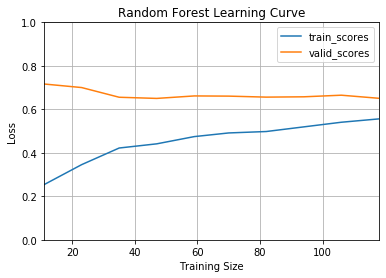

In [27]:
train_sizes, train_scores, valid_scores = learning_curve(rf_walking_model.best_estimator_, 
                                                         walking_X_train, walking_y_train, 
                                                         scoring = "neg_log_loss", 
                                                         cv = 10, random_state = 100, 
                                                         train_sizes = np.linspace(0.1, 1, 10))
pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1) * -1, 
                     "valid_scores": np.mean(valid_scores, axis = 1) * -1}, index = train_sizes).plot()
plt.ylabel("Loss")
plt.title("Random Forest Learning Curve")
plt.ylim(0,1)
plt.xlabel("Training Size")
plt.grid()

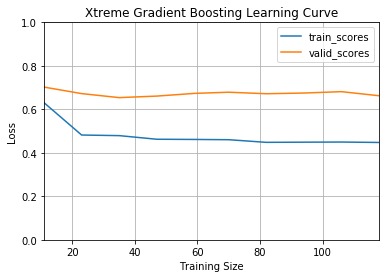

In [28]:
train_sizes, train_scores, valid_scores = learning_curve(xgb_walking_model.best_estimator_, 
                                                         walking_X_train, walking_y_train, 
                                                         scoring = "neg_log_loss", 
                                                         cv = 10, 
                                                         random_state = 100, 
                                                         train_sizes = np.linspace(0.1, 1, 10))
pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1) * -1, 
                     "valid_scores": np.mean(valid_scores, axis = 1) * -1}, index = train_sizes).plot()
plt.ylabel("Loss")
plt.title("Xtreme Gradient Boosting Learning Curve")
plt.ylim(0,1)
plt.xlabel("Training Size")
plt.grid()

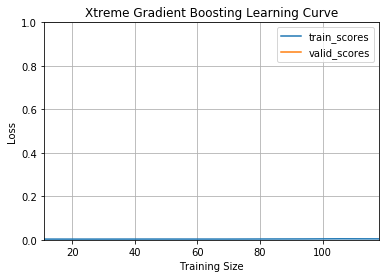

In [29]:
train_sizes, train_scores, valid_scores = learning_curve(gb_walking_model.best_estimator_, 
                                                         walking_X_train, walking_y_train, 
                                                         scoring = "neg_log_loss", 
                                                         cv = 10, 
                                                         random_state = 100, 
                                                         train_sizes = np.linspace(0.1, 1, 10))
pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1) * -1, 
                     "valid_scores": np.mean(valid_scores, axis = 1) * -1}, index = train_sizes).plot()
plt.ylabel("Loss")
plt.title("Xtreme Gradient Boosting Learning Curve")
plt.ylim(0,1)
plt.xlabel("Training Size")
plt.grid()

# Balance Data

In [30]:
balance_train = pd.read_csv("../Data/BALANCE_TRAINING_DATA.csv", index_col=0).reset_index(drop = True)
balance_X_train, balance_X_test, balance_y_train, balance_y_test = \
train_test_split(balance_train.drop(["PD"],axis = 1), balance_train["PD"], test_size=0.20, random_state = 100)

In [31]:
lr_balance_model = logreg_fit(balance_X_train, balance_y_train)
rf_balance_model = randomforest_fit(balance_X_train, balance_y_train)
gb_balance_model = gradientboost_fit(balance_X_train, balance_y_train)
xgb_balance_model = xgb_fit(balance_X_train, balance_y_train)


print("\n### Gradient Boosting Walking ###")
printPerformance(gb_balance_model, balance_X_test, balance_y_test)
print("\n### XTreme Gradient Boosting Walking ###")
printPerformance(xgb_balance_model, balance_X_test, balance_y_test)
print("\n### Random Forest Walking ###")
printPerformance(rf_balance_model, balance_X_test, balance_y_test)
print("\n### Logistic Regression Walking ###")
printPerformance(lr_balance_model, balance_X_test, balance_y_test)


### Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.7145191409897292
Parameter Used: {'classifier__learning_rate': 0.001, 'classifier__loss': 'deviance', 'classifier__max_depth': 2, 'classifier__n_estimators': 100}
ROC-AUC on Test-Set: 0.46825396825396826
log-loss: 19.48382237529844
Precision: 0.4444444444444444
Recall: 0.8888888888888888
F1-Score: 0.5925925925925926

### XTreme Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.6674836601307189
Parameter Used: {'classifier__gamma': 1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8, 'classifier__tree_method': 'hist'}
ROC-AUC on Test-Set: 0.46825396825396826
log-loss: 18.59806920665941
Precision: 0.43478260869565216
Recall: 0.5555555555555556
F1-Score: 0.4878048780487805

### Random Forest Walking ###
Mean AUC score on K-folds: 0.6847572362278244
Parameter Used: {'classifier__criterion': 'entropy', 'classifier__max_depth': 2, 'classifier__m

# Combining Features in Balance and Walking

In [113]:
from sklearn.feature_selection import SelectKBest, chi2

In [135]:
train = pd.concat([balance_train.drop("PD", axis = 1), walking_train], axis = 1)
train = train.groupby(train.columns, axis=1).mean().dropna()
combined_X_train, combined_X_test, combined_y_train, combined_y_test = \
train_test_split(train.drop(["PD"], axis = 1), train["PD"], test_size=0.20, random_state = 100)
selector = SelectKBest(chi2, k=15).fit(combined_X_train, combined_y_train)
pd.Series(data = selector.scores_, index = combined_X_train.columns).sort_values(ascending = False).head(15)

max_userAccel_y.frequency_of_peaks     3.442899e+08
max_userAccel_x.frequency_of_peaks     1.370186e+07
max_userAccel_AA.frequency_of_peaks    8.345348e+05
max_userAccel_z.frequency_of_peaks     4.602456e+04
max_userAccel_x.max_freeze_index       1.208810e+03
max_userAccel_z.max_freeze_index       8.897928e+02
max_userAccel_y.max_freeze_index       3.391854e+02
max_userAccel_x.freeze_occurences      4.986737e+01
max_userAccel_z.freeze_occurences      3.421301e+01
max_userAccel_y.freeze_occurences      1.917437e+01
max_userAccel_AA.freeze_occurences     1.778391e+01
max_userAccel_AA.max_freeze_index      1.230553e+01
max_userAccel_x.no_of_steps            2.433806e+00
max_userAccel_y.no_of_steps            5.537818e-01
max_userAccel_z.no_of_steps            3.679252e-01
dtype: float64

In [136]:
lr_balance_model = logreg_fit(combined_X_train, combined_y_train)
rf_balance_model = randomforest_fit(combined_X_train, combined_y_train)
gb_balance_model = gradientboost_fit(combined_X_train, combined_y_train)
xgb_balance_model = xgb_fit(combined_X_train, combined_y_train)


print("\n### Gradient Boosting Walking ###")
printPerformance(gb_balance_model, combined_X_test, combined_y_test)
print("\n### XTreme Gradient Boosting Walking ###")
printPerformance(xgb_balance_model, combined_X_test, combined_y_test)
print("\n### Random Forest Walking ###")
printPerformance(rf_balance_model, combined_X_test, combined_y_test)
print("\n### Logistic Regression Walking ###")
printPerformance(lr_balance_model, combined_X_test, combined_y_test)


### Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.7072510822510822
Parameter Used: {'classifier__learning_rate': 0.1, 'classifier__loss': 'exponential', 'classifier__max_depth': 6, 'classifier__n_estimators': 100}
ROC-AUC on Test-Set: 0.48351648351648346
log-loss: 18.285516772869254
Precision: 0.3684210526315789
Recall: 0.5384615384615384
F1-Score: 0.4375

### XTreme Gradient Boosting Walking ###
Mean AUC score on K-folds: 0.6821789321789321
Parameter Used: {'classifier__gamma': 1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8, 'classifier__tree_method': 'auto'}
ROC-AUC on Test-Set: 0.5073260073260073
log-loss: 17.269646890741583
Precision: 0.3888888888888889
Recall: 0.5384615384615384
F1-Score: 0.45161290322580644

### Random Forest Walking ###
Mean AUC score on K-folds: 0.7160894660894661
Parameter Used: {'classifier__criterion': 'entropy', 'classifier__max_depth': 9, 'classifier__max_feature

# Saving Serialized Results

The walking models will be the only one taken for further assessment towards V2 data due to its decent performance of ROC-AUC > 0.6. Model will be refitted to the test sets.

In [32]:
import pickle
from sklearn.externals import joblib 

### Refit Model to Tests Sets

In [55]:
refitted_lr = lr_walking_model.best_estimator_.fit(walking_X_test, walking_y_test)
refitted_gb = gb_walking_model.best_estimator_.fit(walking_X_test, walking_y_test)
refitted_xgb = xgb_walking_model.best_estimator_.fit(walking_X_test, walking_y_test)
refitted_rf = rf_walking_model.best_estimator_.fit(walking_X_test, walking_y_test)

In [56]:
models = ["refitted_lr", "refitted_gb", "refitted_xgb", "refitted_rf"]


for model in models:
    joblib.dump(globals()[model], '../Models/{}.pkl'.format(model))